# **Image output is shown for last epoch**

In [3]:
import zipfile
fte = zipfile.ZipFile('/content/dataset.zip','r')
fte.extractall('/content')
fte.close()

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow
from tensorflow import keras
from keras.losses import BinaryCrossentropy
from keras.preprocessing.image import load_img, array_to_img
from keras.models import Sequential, Model

In [6]:
path = '/content/Hackathon_Dataset/train_images'


In [7]:
image_paths=[]
for i in os.listdir(path):
  image_path = os.path.join(path, i)
  image_paths.append(image_path)

In [8]:
len(image_paths)

520

In [10]:
train_images = [np.array(load_img(path)) for path in (image_paths)]
train_images = np.array(train_images)

In [11]:
print(train_images.shape)

(520, 36, 36, 3)


In [12]:
train_images.dtype

dtype('uint8')

In [13]:

train_images = train_images.reshape(train_images.shape[0],36, 36, 3).astype('float32')
train_images = (train_images-127.5)/127.5  #normalizing around zero

In [121]:
from keras import layers
from keras.layers import Dense


Latent_dim = 100
channel = 3
weight_int = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

model = Sequential(name="generator")

#1d random noise
model.add(Dense(9*9*512, input_dim =Latent_dim))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())


#convert 1d to 3d
model.add(layers.Reshape((9,9,512)))

#upsample to 18x18
model.add(layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2) , padding='same', kernel_initializer=weight_int))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

#upsample to 36x36
model.add(layers.Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2) , padding='same', kernel_initializer=weight_int))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.Conv2D(channel, activation='tanh',  kernel_size=(3,3),padding='same' ))


generator = model
generator.summary()




Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 41472)             4188672   
                                                                 
 re_lu_18 (ReLU)             (None, 41472)             0         
                                                                 
 reshape_6 (Reshape)         (None, 9, 9, 512)         0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 18, 18, 256)       2097408   
 DTranspose)                                                     
                                                                 
 re_lu_19 (ReLU)             (None, 18, 18, 256)       0         
                                                                 
 conv2d_transpose_13 (Conv2  (None, 36, 36, 128)       524416    
 DTranspose)                                             

discriminator model

In [122]:
model = Sequential(name="discriminator")
input_shape = (36,36,3)
alpha = 0.15

model.add(layers.Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape= input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4,4), strides=(2,2), padding='same', input_shape= input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4,4), strides=(2,2), padding='same', input_shape= input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation='sigmoid'))
discriminator= model
discriminator.summary()



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 18, 18, 64)        3136      
                                                                 
 batch_normalization_24 (Ba  (None, 18, 18, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 18, 18, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 9, 9, 128)         131200    
                                                                 
 batch_normalization_25 (Ba  (None, 9, 9, 128)         512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 9, 9, 128)       

Creating DCGAN model

In [123]:
class DCGAN(keras.Model):
  def __init__(self, generator, discriminator, latent_dim):
    super().__init__()
    self.generator = generator
    self.discriminator=discriminator
    self.latent_dim = latent_dim
    self.g_loss_metric = keras.metrics.Mean(name='g_loss')
    self.d_loss_metric = keras.metrics.Mean(name='d_loss')

  @property
  def metrics(self):
    return [self.g_loss_metric, self.d_loss_metric]

  def compile(self, g_optimizer, d_optimizer, loss_fn):
    super(DCGAN, self).compile()
    self.g_optimizer = g_optimizer
    self.d_optimizer = d_optimizer
    self.loss_fn = loss_fn

  def train_step(self, real_images):
    batch_size = tensorflow.shape(real_images)[0]
    random_noise = tensorflow.random.normal(shape=(batch_size, self.latent_dim))

    # 0-fake image / 1-real image

    with tensorflow.GradientTape() as tape:
      #computing loss on real images
      pred_real = self.discriminator(real_images, training=True)

      real_labels = tensorflow.ones((batch_size, 1))
      real_labels += 0.05 * tensorflow.random.uniform(tensorflow.shape(real_labels)) # for smoothening
      d_loss_real = self.loss_fn(real_labels, pred_real)

      #computing loss on fake images

      fake_images = self.generator(random_noise)
      pred_fake = self.discriminator(fake_images, training=True)

      fake_labels  = tensorflow.zeros((batch_size, 1))
      d_loss_fake = self.loss_fn(fake_labels, pred_fake)
      d_loss = (d_loss_real + d_loss_fake)/2
    gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
    self.d_optimizer.apply_gradients(zip(gradients,self.discriminator.trainable_variables ))



    #training the genrator model
    labels = tensorflow.ones((batch_size, 1))

    with tensorflow.GradientTape() as tape:
      fake_images = self.generator(random_noise, training = True)

      pred_fake = self.discriminator(fake_images, training = True)

      g_loss = self.loss_fn(labels, pred_fake)

    #computing gradients to update the model
    gradients = tape.gradient(g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

    #updating state for both models
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}




In [124]:
class DCGANMonitor(keras.callbacks.Callback):
  def __init__(self, num_imgs=25, latent_dim=100):
    self.num_imgs = num_imgs
    self.latent_dim = latent_dim
    self.noise = tensorflow.random.normal([25,latent_dim])  # 25 images to be created
    self.last_epoch = 0

  def on_epoch_end(self, epoch, logs=None):
    self.last_epoch = epoch  # Update the last epoch

  def on_train_end(self, logs=None):
    if self.last_epoch == (self.params['epochs'] - 1):  # Check if it's the last epoch
      # Generate and display the images only for the last epoch
      # Generate the image from noise
      g_img = self.model.generator(self.noise)
      g_img = (g_img * 127.5) + 127.5  # Denormalize the image values
      g_img.numpy()

      fig = plt.figure(figsize=(8, 8))
      for i in range(self.num_imgs):
        plt.subplot(5, 5, i + 1)
        img = array_to_img(g_img[i])
        plt.imshow(img)
        plt.axis('off')
      plt.suptitle(f"Generated Images - Epoch {self.last_epoch + 1}")
      plt.show()

      # Save the generator model
      self.model.generator.save('generator.h5')


In [125]:
dcgan = DCGAN(generator = generator, discriminator=discriminator, latent_dim=Latent_dim)

In [126]:
D_LR = 0.00012
G_LR = 0.00035  
#generator will learn more rapidly relative to discriminator

In [127]:
from keras.optimizers import Adam
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.45),d_optimizer=Adam(learning_rate=D_LR, beta_1=0.45), loss_fn=BinaryCrossentropy())

Epoch 1/500
17/17 [==============================] - 1s 50ms/step - d_loss: 0.1967 - g_loss: 2.3741
Epoch 2/500
17/17 [==============================] - 1s 46ms/step - d_loss: 0.1627 - g_loss: 2.4803
Epoch 3/500
17/17 [==============================] - 1s 46ms/step - d_loss: 0.1659 - g_loss: 2.4996
Epoch 4/500
17/17 [==============================] - 1s 47ms/step - d_loss: 0.1838 - g_loss: 2.6267
Epoch 5/500
17/17 [==============================] - 1s 47ms/step - d_loss: 0.2406 - g_loss: 2.5072
Epoch 6/500
17/17 [==============================] - 1s 48ms/step - d_loss: 0.1773 - g_loss: 2.4746
Epoch 7/500
17/17 [==============================] - 1s 49ms/step - d_loss: 0.1603 - g_loss: 2.4631
Epoch 8/500
17/17 [==============================] - 1s 50ms/step - d_loss: 0.2758 - g_loss: 2.6603
Epoch 9/500
17/17 [==============================] - 1s 46ms/step - d_loss: 0.1698 - g_loss: 2.3213
Epoch 10/500
17/17 [==============================] - 1s 46ms/step - d_loss: 0.2668 - g_loss: 2.3981

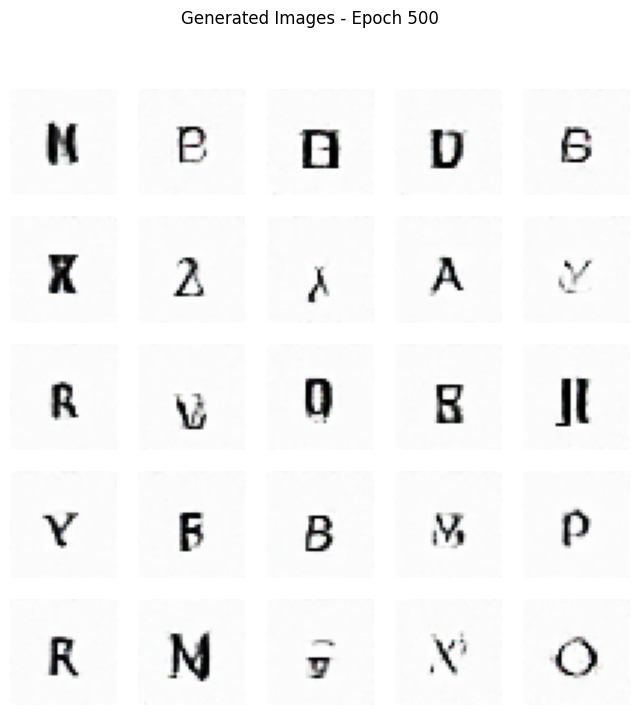

In [131]:
n_epochs =500
monitor = DCGANMonitor()
history = dcgan.fit(train_images, epochs = n_epochs, callbacks=[DCGANMonitor()], verbose=1 )

In [132]:
generator_loss = history.history['g_loss']
discriminator_loss = history.history['d_loss']

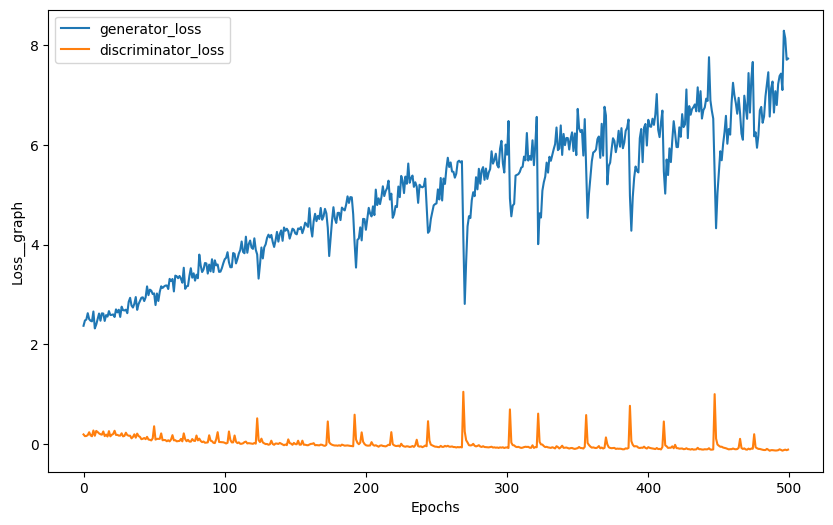

In [133]:
plt.figure(figsize=(10,6))
plt.plot( generator_loss, label='generator_loss')
plt.plot( discriminator_loss, label='discriminator_loss')
plt.ylabel('Loss__graph')
plt.xlabel('Epochs')
plt.legend()
plt.show()
